In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading keras and FBD experiment...
from keras import backend as K
K.set_floatx('float32')
from helpers import *
from model_conv import *
from experiment_model import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np
from IPython.display import Image, display

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input
from keras.layers import Activation

# loading resnet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions

Using TensorFlow backend.


Initialized TensorFlow


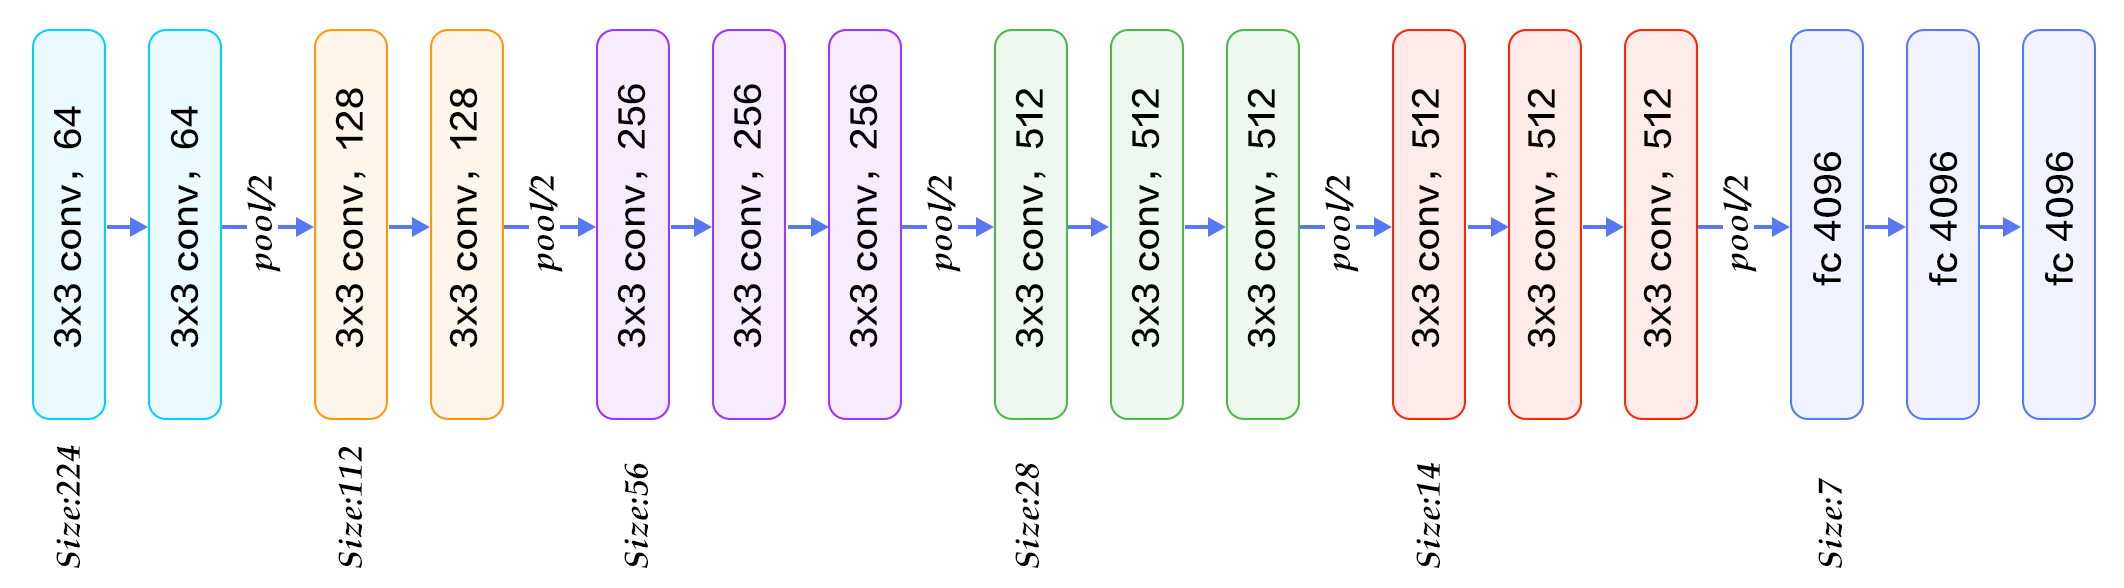

In [2]:
# creating vgg16 model
model = VGG16(weights = 'imagenet')

In [3]:
# replacing ReLU with Softplus(2)
model = replace_relu_with_softplus(model, scaler = 2.0)

Replacing ReLU to Softplus(2.00)
Replacing activation relu on layer 1/<keras.layers.convolutional.Conv2D object at 0x7f605010c6a0> with softplus
Replacing activation relu on layer 2/<keras.layers.convolutional.Conv2D object at 0x7f605010c4e0> with softplus
Replacing activation relu on layer 4/<keras.layers.convolutional.Conv2D object at 0x7f5f801044e0> with softplus
Replacing activation relu on layer 5/<keras.layers.convolutional.Conv2D object at 0x7f5f80122e10> with softplus
Replacing activation relu on layer 7/<keras.layers.convolutional.Conv2D object at 0x7f5f800da128> with softplus
Replacing activation relu on layer 8/<keras.layers.convolutional.Conv2D object at 0x7f5f800f6518> with softplus
Replacing activation relu on layer 9/<keras.layers.convolutional.Conv2D object at 0x7f5f800970b8> with softplus
Replacing activation relu on layer 11/<keras.layers.convolutional.Conv2D object at 0x7f5f800481d0> with softplus
Replacing activation relu on layer 12/<keras.layers.convolutional.Conv

/localhome/xxxx/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
# output layer
l = -1

# choosing only this output layer
model_cut = cut_and_flatten(model, l)

In [5]:
d = 10
model_upscale = upscale_from(model_cut, d)

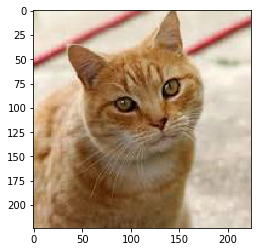

In [5]:
# loading the cat image
x = load_cat(224)

In [6]:
# making only 10 entries in the red channel column 0 faulty
rc0 = 10
x, x_without_first = split_x_rc0(x, rc0 = rc0)

In [7]:
# create a model which adds the rest
model_upscale = merge_with_taken(model_cut, x_without_first, rc0 = rc0)

In [8]:
if l == -1:
    print(decode_predictions(model_upscale.predict(x), top=3)[0])
else:
    print(model_upscale.predict(x))

[('n02124075', 'Egyptian_cat', 0.54772985), ('n02123045', 'tabby', 0.2772738), ('n02127052', 'lynx', 0.109289266)]


In [9]:
# probability of input failure
p = 0.5

In [10]:
# calculating np
n = np.prod(list(map(int, model_upscale.inputs[0].shape[1:])))
n, n * p

(10, 5.0)

In [11]:
# keeping indices with the largest output probability
to_keep = np.array(np.argsort(-model_upscale.predict(x))[0][:5], dtype = np.int32)

In [12]:
print('Keeping output indices ' + ', '.join([str(t) for t in to_keep]))

Keeping output indices 285, 281, 287, 282, 728


In [13]:
# model with only these indices kept
model_slice = keep_oindices(model_upscale, to_keep)

In [14]:
# obtaining experiment from a model
exp = ModelInputCrashExperiment(model_slice, p = p)

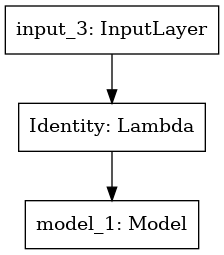

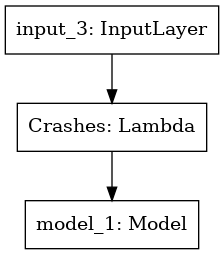

In [15]:
# showing correct/crashing models
display(Image(model_to_dot(exp.model_correct, ).create(prog='dot', format='png'), width = 80))
display(Image(model_to_dot(exp.model_crashing).create(prog='dot', format='png'), width = 80))

In [16]:
# crashing prediction
decode_predictions(predict_kept(exp.model_crashing, x, to_keep), top=3)[0]

[('n02124075', 'Egyptian_cat', 0.5424628257751465),
 ('n02123045', 'tabby', 0.27843499183654785),
 ('n02127052', 'lynx', 0.11272622644901276)]

In [17]:
# correct prediction
decode_predictions(predict_kept(exp.model_correct, x, to_keep), top=3)[0]

[('n02124075', 'Egyptian_cat', 0.5477298498153687),
 ('n02123045', 'tabby', 0.2772738039493561),
 ('n02127052', 'lynx', 0.1092892661690712)]

In [18]:
# get theoretical error (bound b3)
exp.get_bound_b3(x)

{'mean': array([-0.00300784,  0.00162346,  0.00070267,  0.00030872,  0.00021351],
       dtype=float32),
 'std': array([0.0021581 , 0.00126958, 0.00147798, 0.00017295, 0.00027652],
       dtype=float32)}

In [19]:
# get experimental error
experiment_mean_std(exp, x, repetitions = 1000)

{'mean': array([[-0.00491802,  0.00111128,  0.00322748,  0.00072508, -0.00020338]],
       dtype=float32),
 'std': array([[0.00112425, 0.00059046, 0.00109083, 0.00018689, 0.00017929]],
       dtype=float32)}